In [1]:
import torch
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.carga_datos import PrepararDatos
from src.modelo import ModeloCNN
from src.mapa_caracteristicas import visualizar_mapas

In [2]:
ruta_config: str = 'C:/Users/usuario/PycharmProjects/CNN2.0/config/config.yaml'

with open(ruta_config, 'r') as archivo:
    configuraciones = yaml.safe_load(archivo)

train_dir = f".{configuraciones['directorios']['entrenamiento']}"
val_dir = f".{configuraciones['directorios']['validacion']}"
test_dir = f".{configuraciones['directorios']['prueba']}"
modelo_path = f".{configuraciones['directorios']['modelo_ok']}"
tamano_imagen = configuraciones['entrenamiento']['tamano_imagen']
batch_size = configuraciones['entrenamiento']['tamano_batch']
dropout = configuraciones['entrenamiento']['dropout']

dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {dispositivo}")

Usando dispositivo: cuda


In [3]:
preparar_datos = PrepararDatos(tamano_imagen)
_, _, loader_prueba = preparar_datos.obtener_datasets(train_dir, val_dir, test_dir, batch_size)
print("Datos de prueba cargados correctamente.")


Distribución de clases en el conjunto de entrenamiento:
etiqueta
1    2968
0    2216
Name: count, dtype: int64

Distribución de clases en el conjunto de validación:
etiqueta
1    636
0    237
Name: count, dtype: int64

Distribución de clases en el conjunto de prueba:
etiqueta
1    637
0    238
Name: count, dtype: int64
Datos de prueba cargados correctamente.


In [4]:
# FIXME: Arreglar llaves para el diccionario del modelo

modelo = ModeloCNN(dropout=dropout)
modelo.load_state_dict(torch.load(modelo_path, map_location=dispositivo, weights_only=True))
modelo.to(dispositivo)
modelo.eval()
print("Modelo cargado correctamente.")

RuntimeError: Error(s) in loading state_dict for ModeloCNN:
	Missing key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "conv3.weight", "conv3.bias", "conv4.weight", "conv4.bias", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "bn3.weight", "bn3.bias", "bn3.running_mean", "bn3.running_var", "bn4.weight", "bn4.bias", "bn4.running_mean", "bn4.running_var", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias", "fc4.weight", "fc4.bias". 
	Unexpected key(s) in state_dict: "state_dict", "best_acc". 

In [ ]:
imagen, _ = next(iter(loader_prueba))
imagen = imagen.to(dispositivo)

visualizar_mapas(modelo, imagen, capa_idx=0)

In [5]:
def evaluar_modelo(modelo, loader):
    modelo.eval()
    todas_predicciones = []
    todas_etiquetas = []

    with torch.no_grad():
        for imagenes, etiquetas in loader:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            salidas = modelo(imagenes)
            _, predicciones = torch.max(salidas, 1)
            todas_predicciones.extend(predicciones.cpu().numpy())
            todas_etiquetas.extend(etiquetas.cpu().numpy())

    return todas_etiquetas, todas_predicciones

Accuracy del modelo_entrenado: 0.962

Reporte de clasificación:

              precision    recall  f1-score   support

      Normal       0.93      0.94      0.93       238
   Pneumonia       0.98      0.97      0.97       637

    accuracy                           0.96       875
   macro avg       0.95      0.95      0.95       875
weighted avg       0.96      0.96      0.96       875



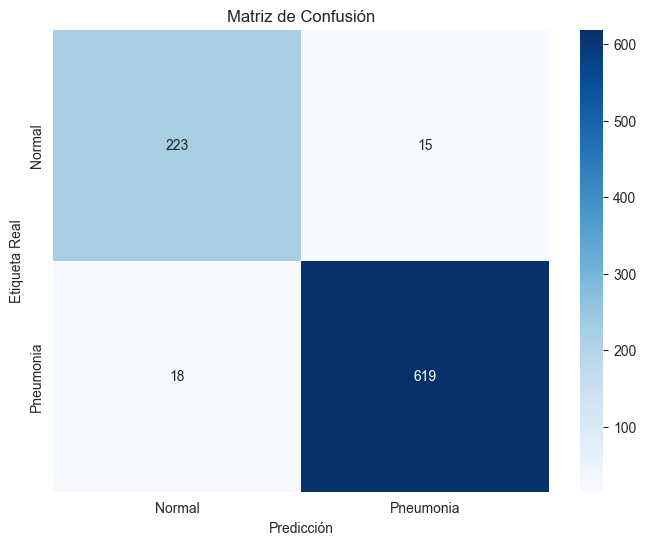

In [6]:
y_true, y_pred = evaluar_modelo(modelo, loader_prueba)
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy del modelo_entrenado: {accuracy:.3f}")

print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.show()

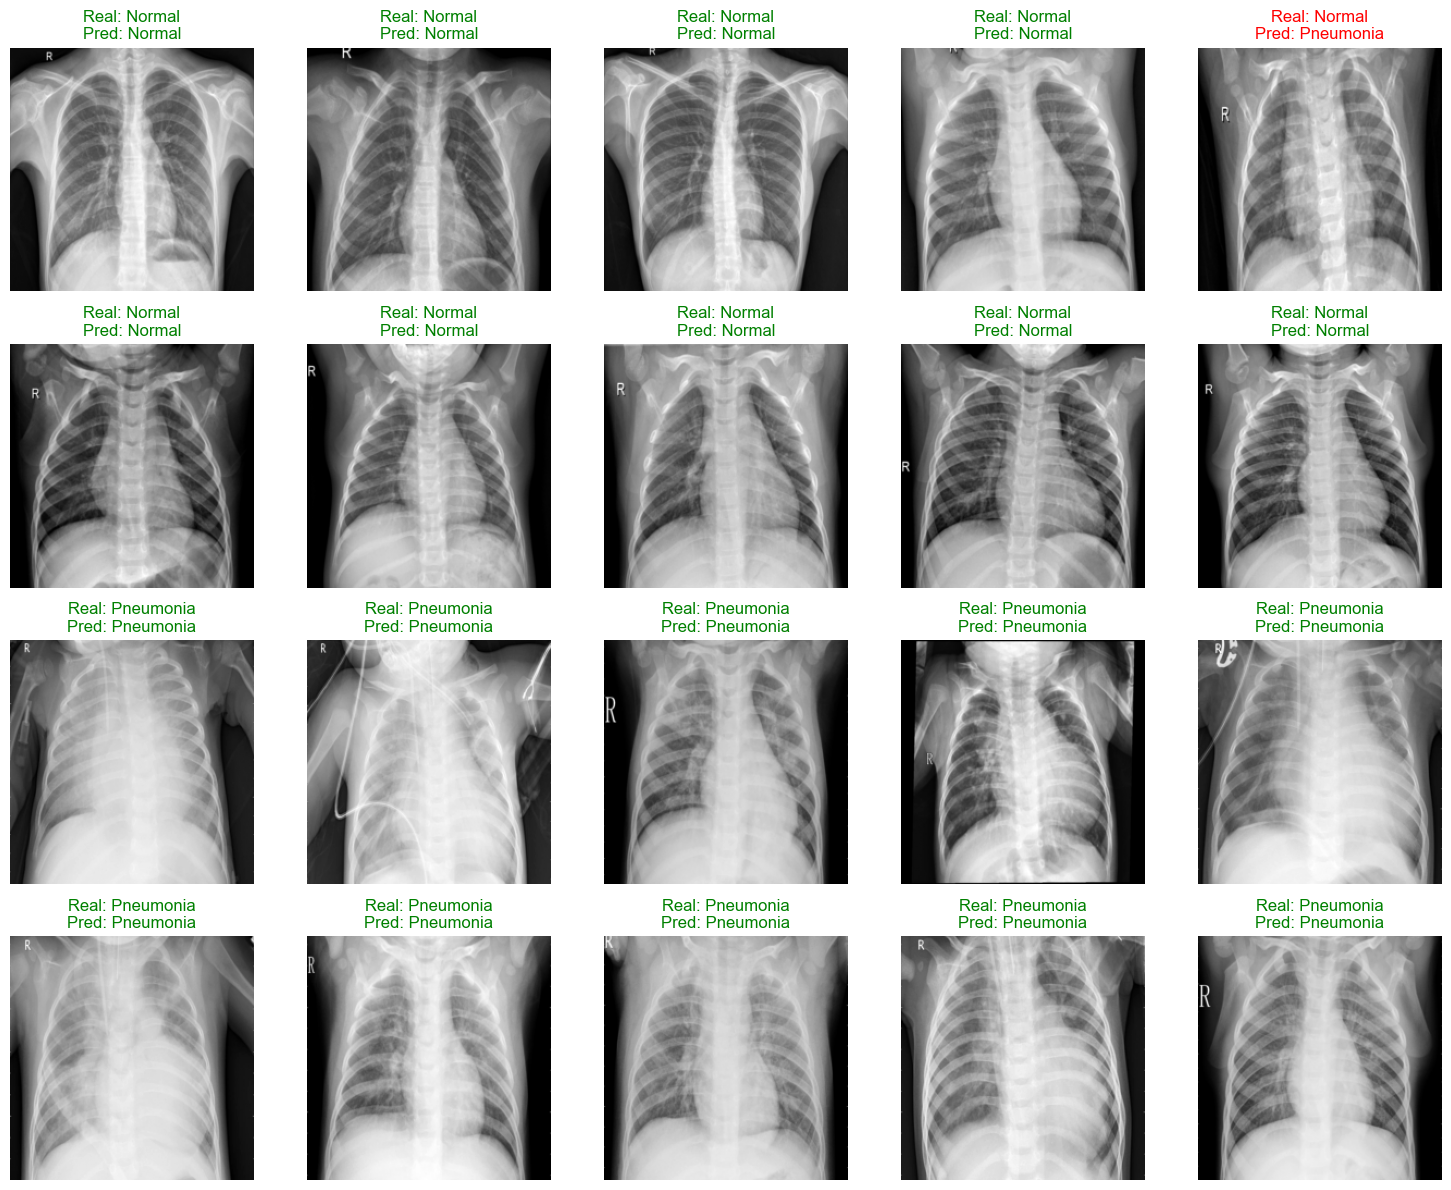

In [8]:
def mostrar_predicciones_balanceadas(modelo, loader, nombres_clases, num_normal=10, num_pneumonia=10):
    modelo.eval()
    imagenes_normales = []
    imagenes_neumonia = []

    with torch.no_grad():
        for imagenes, etiquetas in loader:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            salidas = modelo(imagenes)
            _, predicciones = torch.max(salidas, 1)

            for i in range(imagenes.size(0)):
                img = imagenes[i].cpu().numpy().transpose(1, 2, 0)
                if img.shape[-1] == 1:
                    img = img.squeeze(-1)

                etiqueta_real = etiquetas[i].item()
                etiqueta_predicha = predicciones[i].item()

                detalle = {
                    "imagen": img,
                    "etiqueta_real": nombres_clases[etiqueta_real],
                    "etiqueta_predicha": nombres_clases[etiqueta_predicha],
                    "correcto": etiqueta_real == etiqueta_predicha,
                }

                if etiqueta_real == 0 and len(imagenes_normales) < num_normal:
                    imagenes_normales.append(detalle)
                elif etiqueta_real == 1 and len(imagenes_neumonia) < num_pneumonia:
                    imagenes_neumonia.append(detalle)

            if len(imagenes_normales) >= num_normal and len(imagenes_neumonia) >= num_pneumonia:
                break

    todas_imagenes = imagenes_normales + imagenes_neumonia
    filas, columnas = 4, 5
    fig, axes = plt.subplots(filas, columnas, figsize=(15, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(todas_imagenes):
            img_info = todas_imagenes[idx]
            img = img_info["imagen"]
            etiqueta_real = img_info["etiqueta_real"]
            etiqueta_predicha = img_info["etiqueta_predicha"]
            correcto = img_info["correcto"]

            color_titulo = "green" if correcto else "red"
            ax.imshow(img, cmap="gray" if img.ndim == 2 else None)
            ax.set_title(f"Real: {etiqueta_real}\nPred: {etiqueta_predicha}", color=color_titulo)
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

mostrar_predicciones_balanceadas(modelo, loader_prueba, ["Normal", "Pneumonia"], num_normal=10, num_pneumonia=10)